## Summary:
Example put together by Jane Baldwin for Mona Hemmati on 7-13-21.
Shows how to determine landfalling TC tracks and calculate wind swaths from them-- in this case for the Philippines.
Code is set up to run on Berimbau, but could be adapted for other computing systems.

## Step 0: Load packages

In [29]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [30]:
#!/usr/bin/env python

# standard packages
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from pyproj import Proj, transform
import math
import multiprocessing
from joblib import Parallel, delayed
import time
from os import path

# specialized CHAZ packages
from chaz.utility import knaff15
from pygplib3 import readbst
from pygplib3 import landfall as ld
from tcrisk.hazard import windfield, landfall_in_box, timepoints_around_landfall


In [32]:
# # For timing the script
# start_time = time.time()

## Step 1a: Define regional bounding box for Philippines

In [31]:
# Bounding box for the Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625


## Step 1b: Load data for TC tracks.

In [10]:
# Load data from file
filename = '/data2/clee/bttracks/IBTrACS.ALL.v04r00.nc'
ibtracs = readbst.read_ibtracs_v4(filename,'wnp',2) # gap = 2 to convert 3-hourly to 6-hourly

# Extract variables
lon = ibtracs.lon[:]
lat = ibtracs.lat[:]
wspd = ibtracs.wspd[:] # wind speed in knots
days = ibtracs.days[:] # date in days
dist2land = ibtracs.dist2land[:]
year = ibtracs.year[:]


## Step 1c: Interpolate data from 6-hour to 15-min timesteps.

In [11]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon_int = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat_int = ld.rescale_matrix(lat,nscale,0)
wspd_int = ld.rescale_matrix(wspd,nscale,0)
days = np.where(days==-9999000., np.nan, days)
days_int = ld.rescale_matrix(days,nscale,0)

## Step 1d: Calculate which storms make landfall in the Philippines, and subset only those storms.
Note: takes a couple minutes.

In [14]:
# Calculate which storms and when make landfall in Philippines
nSlandfall_all_phi, iTlandfall_all_phi, nSlandfall_phi = landfall_in_box(lonmin,lonmax,latmin,latmax,lon_int,lat_int,wspd_int)

CPU times: user 1min 42s, sys: 1.15 s, total: 1min 43s
Wall time: 1min 43s


In [15]:
# Select data only for storms that make landfall in the Philippines
# (for normal timesteps and interpolated timestep data)
lon_phi = lon[:,nSlandfall_phi]
lat_phi = lat[:,nSlandfall_phi]
wspd_phi = wspd[:,nSlandfall_phi]
days_phi = days[:,nSlandfall_phi]
year_phi = year[nSlandfall_phi]

lon_int_phi = lon_int[:,nSlandfall_phi]
lat_int_phi = lat_int[:,nSlandfall_phi]
wspd_int_phi = wspd_int[:,nSlandfall_phi]
days_int_phi = days_int[:,nSlandfall_phi]

## Step 1e: Save out data for storms that make landfall in the Philippines.

In [73]:
# Save out data of Philippines landfalling TCs
ds = xr.Dataset(
    {"lon": (("iT","nS"), lon_phi),
     "lat": (("iT","nS"), lat_phi),
     "wspd": (("iT","nS"), wspd_phi), # maximum sustained wind speed in m/s
     "days": (("iT","nS"), days_phi),
     "year": (("nS"), year_phi)},
        coords={
        "iT": np.arange(np.shape(lon_phi)[0]),
        "nS": np.arange(np.shape(lon_phi)[1]),
     },
 )

ds.to_netcdf("/home/jbaldwin/WorldBank/WIND_HAZARD/IBTRACS_LANDFALL_TRACKS/ibtracsv04r00_landfall_philippines.nc", mode = 'w')


NameError: name 'lon_phi' is not defined

## Step 2a: Load data for TC tracks making landfall in Philippines.

In [33]:
# Load subset data of landfalling storms over Philippines
dat = xr.open_dataset('/home/jbaldwin/WorldBank/WIND_HAZARD/IBTRACS_LANDFALL_TRACKS/ibtracsv04r00_landfall_philippines.nc')
lon = np.array(dat.lon)
lat = np.array(dat.lat)
wspd = np.array(dat.wspd)/1.944 #convert from kts to m/s
days = np.array(dat.days)
year = np.array(dat.year)


## Step 2b: Calculate track angle and translation speed (which is necessary for asymmetry correction).

In [34]:
# Calculate track angle and track translation speed 
er = 6371.0  # earth's radius; km
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360) # longitude distance at a latitude; km
dx = londis*1000*lon_diff # meters
dy = 110.*1000*lat_diff # meters
time_diff = (days[1:, :] - days[0:-1, :])*24.*60*60 # seconds
tr = old_div(np.sqrt(dx**2+dy**2),(time_diff)) # track translation speed
trDir = np.arctan2(lat_diff, lon_diff) # track angle
# note: subtraction cuts off point at end, might need to add one final track direction and speed point if get errors later

## Step 2c: Interpolate data from 6-hour to 15-min timesteps.

In [35]:
# Interpolate to 15-min timesteps
nscale = 24 # convert from 6-hr to 15-min timesteps (factor of 6*4=24)
lon = ld.rescale_matrix(lon,nscale,0) # int for time interpolated 
lat = ld.rescale_matrix(lat,nscale,0)
wspd = ld.rescale_matrix(wspd,nscale,0)
days = ld.rescale_matrix(days,nscale,0)
tr = ld.rescale_matrix(tr,nscale,0)
trDir = ld.rescale_matrix(trDir,nscale,0)

## Step 2d: Calculate which storms make landfall in the Philippines, and times of landfall.
Note: takes 30 or so seconds.

In [36]:
# Calculate which storms and when make landfall in Philippines
nSlandfall_all_phi, iTlandfall_all_phi, nSlandfall_phi = landfall_in_box(lonmin,lonmax,latmin,latmax,lon,lat,wspd)


CPU times: user 22.7 s, sys: 36.1 ms, total: 22.8 s
Wall time: 22.8 s


### Optional: Plot to check landfall calculation.

Text(0.5, 1.0, 'Tracks and Philippines Landfalls of IBTrACS Typhoons')

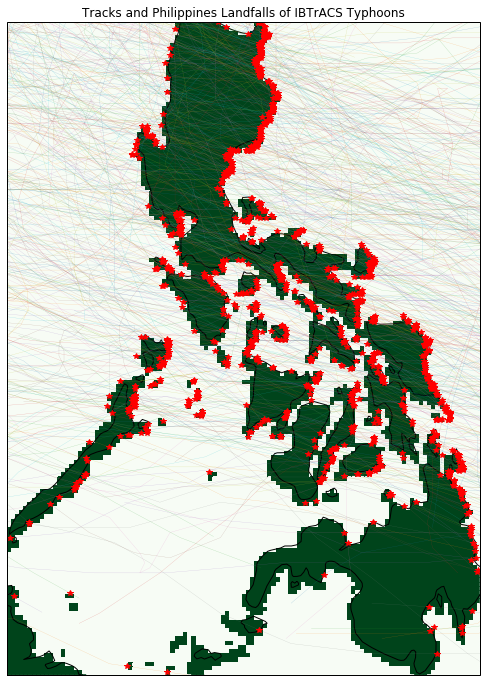

In [37]:
# Plotting tracks and landfall locations

llon, llat, ldmask = ld.get_landmask('/home/clee/CHAZ/landmask.nc')

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for n in range(np.shape(lon)[1]):
    plt.plot(lon[:,n],lat[:,n],linewidth=0.25,alpha=0.4)
for j in range(len(nSlandfall_all_phi)):
    i = iTlandfall_all_phi[j]
    n = nSlandfall_all_phi[j]
    plt.plot(lon[i,n],lat[i,n],'*',color='r')

ax.set_extent([lonmin,lonmax,latmin,latmax])
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_title('Tracks and Philippines Landfalls of IBTrACS Typhoons')

## Step 2e: Subset time for 1 day before and 1 day after landfall, including possibility of multiple landfalls.

In [38]:
# For each storm select time points of landfall, including possibility for second landfall and potential overlap
days_before_landfall = 1
days_post_landfall = 1
timeres = 96 # 4*24 15-min timesteps in 1 day
iTlandfall_forwindfield_phi = timepoints_around_landfall( days_before_landfall, days_post_landfall, nSlandfall_all_phi, iTlandfall_all_phi, wspd, tr, timeres)


### Optional: Plot to check time subset.

Text(0.5, 1.0, 'IBTrACS Typhoons Tracks 1 Day Before and 1 Day After Landfall')

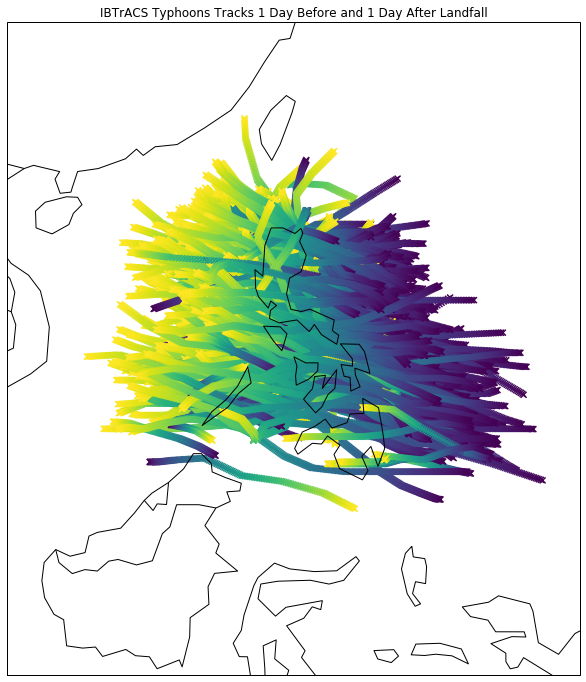

In [39]:
# Plotting tracks 1 day before and after landfall

plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.pcolormesh(llon,llat,ldmask,cmap=plt.cm.Greens)

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    plt.scatter(lon[iT,nS],lat[iT,nS],marker='x',c=np.arange(0,len(lon[iT,nS]),1),cmap=plt.cm.viridis)

ax.set_extent([lonmin-10,lonmax+10,latmin-10,latmax+10])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title('IBTrACS Typhoons Tracks 1 Day Before and 1 Day After Landfall')

In [40]:
# Aggregate only storm points (lat,lon,wspd) where might be making landfall
wspd_landfall = []
lon_landfall = []
lat_landfall = []
days_landfall = []
tr_landfall = []
trDir_landfall = []
year_landfall = []

for nS in range(np.shape(lon)[1]):
    iT = iTlandfall_forwindfield_phi[nS]
    wspd_landfall.append(wspd[iT,nS])
    lon_landfall.append(lon[iT,nS])
    lat_landfall.append(lat[iT,nS])
    days_landfall.append(days[iT,nS])
    tr_landfall.append(tr[iT,nS])
    trDir_landfall.append(trDir[iT,nS])

## Step 2f: create lat-lon grid to put wind fields on.

In [41]:
# Define x-y grid to put profile on
X = np.arange(116.5,127.6,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
Y = np.arange(4.5,19.1,0.1) #Philippines lon rounded to nearest whole degree (down for min, up for max), plus 0.5deg further for wind radius
X1, Y1 = np.meshgrid(X,Y)


## Step 2g: parallelize to calculate wind field for all time points of 1 storm
* In example here we calculate for two storms including Typhoon Haiyan, which corresponds to nS = 434.

In [42]:
# Calculate wind fields, and save out as swaths for two sample storms

for nS in [10,434]: #np.arange(390,len(wspd_landfall),1):
    print(nS)
    
    # Select data for 1 storm
    wspd_nS = wspd_landfall[nS][:]
    lon_nS = lon_landfall[nS][:]
    lat_nS = lat_landfall[nS][:]
    days_nS = days_landfall[nS][:]
    tr_nS = tr_landfall[nS][:]
    trDir_nS = trDir_landfall[nS][:]
    
    # Calculate radius of maximum wind
    rmax_nS = knaff15(wspd_nS*1.944, lat_nS)  #  wspd should be input in kts, outputs in km
    rmax_min = 20 # km
    rmax_nS[np.where(rmax_nS<rmax_min)] = rmax_min # 6-12-20: set places with radii less than 0 to 20 km to fix convergence
    
    # Calculate wind fields in parallel
    stormpoints = np.shape(wspd_nS)[0]
    
    n_processors = 16 # use 16 out of 32 total processors on Berimbau
    wspdmaps = Parallel(n_jobs=n_processors, prefer="threads")(delayed(windfield)(X1, Y1, lon_nS,lat_nS,wspd_nS,rmax_nS,tr_nS,trDir_nS,i) for i in range(stormpoints))    
    wspdmaps = np.abs(wspdmaps) # take absolute value for places asymmetry correction overpowers wind speed
    wspdmaps = np.expand_dims(wspdmaps,axis = 0)  

    swath = np.nanmax(wspdmaps, axis = 1) # Calculate swath over windfields; nanmax to ignore timepoints that don't have windfields

    # Create swath dataset
    ds = xr.Dataset(
     {"swath": (("nS", "lat", "lon"), swath),
      "days": (("nS","iT"), np.expand_dims(days_nS,axis=0)),
      "year": (("nS"), [year[nS]])},
         coords={
        "nS":np.array([nS]),
        "iT":np.arange(stormpoints),
        "lat": Y,
        "lon": X,
     },
     )

    #Write to netcdf
    direc = '/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/TEST/'
    filename = 'wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_7-12-21.nc'
    if path.exists(direc+filename): # concatenate if file exists
         ds_swaths = xr.open_dataset(direc+filename)
         ds_swaths2 = xr.concat([ds_swaths,ds],dim='nS')
         ds_swaths.close() # need to do this before can save out to same file
         ds_swaths2.to_netcdf(direc+filename,mode='w')
    else: #if not create new file
         ds.to_netcdf(direc+filename,mode='w',unlimited_dims = ["nS"])
        
#print("My program took", time.time() - start_time, "to run and had ", missed_tries, " missed tries.")


10
434


# Check handiwork:

Text(0.5, 1.05, 'TYPHOON HAIYAN WIND SWATH [m/s]')

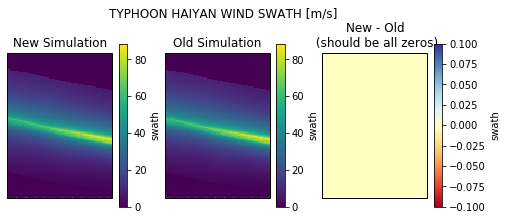

In [71]:
plt.figure(figsize=(8, 3))

ax = plt.subplot(131, projection=ccrs.PlateCarree())
new_dat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/TEST/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_7-12-21.nc')
new_dat.swath.sel(nS=434).plot()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('New Simulation')

ax = plt.subplot(132,projection=ccrs.PlateCarree())
old_dat = xr.open_dataset('/data2/jbaldwin/WINDFIELDS/IBTRACS/PHI/SWATHS/wspd_phi_swaths_maxasymcorrec_ibtracsv04r00_3-8-21.nc')
old_dat.swath.sel(nS=434).plot()
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('Old Simulation')

ax = plt.subplot(133,projection=ccrs.PlateCarree())
(new_dat-old_dat).swath.sel(nS=434).plot(cmap=plt.cm.RdYlBu)
ax.set_extent([lonmin,lonmax,latmin,latmax])
plt.title('New - Old\n (should be all zeros)')

plt.suptitle('TYPHOON HAIYAN WIND SWATH [m/s]',y=1.05)